In this program we will solve a reaction diffusion equation based on your input. 
The equation we work with is as follows:

# Diffusion equation: 
\begin{equation}
    \frac{\partial u}{\partial t} = D\frac{\partial^2u}{\partial x^2} + f(x, t, u)
\end{equation}

\begin{equation}
    u_{i,k+1} - D(\Delta t)\frac{u_{i-1,k+1}-2u_{i,k+1}+u_{i+1,k+1}}{2(\Delta x)^2}
    = u_{i,k} + D(\Delta t)\frac{u_{i-1,k}-2u_{i,k}+u_{i+1,k}}{2(\Delta x)^2} + (\Delta t)f(x_i,t_k,u_{i,k})
\end{equation}

In [1]:
abstract type BoundaryCondition
end

type Dirichlet <: BoundaryCondition 
    ū₀::Float64
    ūₗ::Float64
end

type Neumann <: BoundaryCondition
    ∂ū₀::Float64
    ∂ūₗ::Float64
end 

type Periodic <: BoundaryCondition 
end 

type Discretization
    Nₓ::Int64
    Δx::Float64
    Nₜ::Int64
    Δt::Float64
end 

type SpaceTime
    L::Float64 #spacial extent 
    tf::Float64 #time span of simulation 
end

"""
Determine the number of spatial unknowns at each time step.
"""
function nb_spatial_unknowns(discretization::Discretization, bc::BoundaryCondition)
    if typeof(bc) == Neumann
        return discretization.Nₓ
    elseif typeof(bc) == Dirichlet
        return discretization.Nₓ - 2
    elseif typeof(bc) == Periodic
        return discretization.Nₓ - 1
    end
end

"""
Create tridiagonal matrix.
"""
function build_tri_diagonal_matrix(discretization::Discretization, λ::Float64, bc::BoundaryCondition)
    # determine number of unknowns based on boundary condition
    matrix_dim = nb_spatial_unknowns(discretization, bc)
    
    A = zeros(matrix_dim, matrix_dim)
    
    for i = 1:matrix_dim
        A[i, i] = 1 + 2 * λ
    end
        
    for i = 1:matrix_dim - 1
        A[i  , i+1] = -λ
        A[i+1, i  ] = -λ
    end
    
    if typeof(bc) == Periodic
        A[1, end] = -λ
        A[end, 1] = -λ
    end
        
    if typeof(bc) == Neumann
        A[1, 2] = -2 * λ
        A[end, end - 1] = -2 * λ
    end 
    
    return A
        
end

In [ ]:
using Calculus
using ProgressMeter
"""
Arguments:
* f: reaction term f(x, t, u)
* u₀: initial condition u₀(x)
* bc::BoundaryCondition: boundary condition
* D::Float64: diffusion coefficient
* Nₓ::Int: number of spatial discretization points
* st::SpaceTime: space-time over which solution to PDE is approximated
* sample_time::Float64: stores u every sample_time time steps
"""
function solve_rxn_diffn_eqn(f, u₀, bc::BoundaryCondition, D::Float64, Nₓ::Int, st::SpaceTime, sample_time::Float64)

    # compute Δx, Nₜ, Δt below.
    discretization = Discretization(Nₓ, NaN, 0, NaN)

    # ensure that the boundary condition is consistent with the initial condition
    if isa(bc, Dirichlet)
        @assert(bc.ū₀ ≈ u₀(0.0),
            "The initial condition is inconsistent with Dirichlet boundary condition.")
        @assert(isapprox(bc.ūₗ, u₀(st.L), atol = 1e-10),
            "The initial condition is inconsistent with Dirichlet boundary condition.")
    elseif isa(bc, Periodic)
        @assert(u₀(0.0) ≈ u₀(st.L),
            "The initial condition is inconsistent with Periodic boundary conditions.")
    elseif isa(bc, Neumann)
        @assert(isapprox(bc.∂ū₀, derivative(u₀, 0.0), atol = 1e-10),
            "The initial condition is inconsistent with Neumann boundary condition.")
        @assert(isapprox(bc.∂ūₗ, derivative(u₀, st.L), atol = 1e-10),
            "The initial condition is inconsistent with Neumann boundary condition.")
    end

    # discretize space.
    x = collect(linspace(0, st.L, discretization.Nₓ)) # includes end points!
    discretization.Δx = x[2] - x[1]
    @printf("%d points in x-discretization. dx = %f\n", discretization.Nₓ, discretization.Δx)

    # discreteize time.
    discretization.Δt = discretization.Δx ^ 2
    discretization.Nₜ = ceil(Int, st.tf / discretization.Δt)
    @printf("%d points in t-discretization. dt = %f\n", discretization.Nₜ, discretization.Δt)

    # nondimensional parameter involved in discreteization
    λ = (D * discretization.Δt) / (2 * (discretization.Δx) ^ 2)

    # build tri-diagonal matrix
    A = build_tri_diagonal_matrix(discretization, λ, bc)

    nb_unknowns = nb_spatial_unknowns(discretization, bc)

    # initialize u at k = 0
    # this u is the value of u(x, t) when t = k - 1 over discretized x points.
    u = u₀.(x)

    # trim u and x so that i index corresponds to xᵢ and uᵢ,ₖ
    if typeof(bc) == Neumann
        # all are unknown, no trimming required
    elseif typeof(bc) == Dirichlet
        u = u[2:end-1]
        x = x[2:end-1]
    elseif typeof(bc) == Periodic
        u = u[1:end-1]
        x = x[1:end-1]
    end
    @assert(length(u) == nb_unknowns)
    @assert(length(x) == nb_unknowns)

    # initialize right-hand side of matrix eqn. solved at each time step.
    rhs = zeros(Float64, nb_unknowns)

    # initialize u_sample and t_sample to be filled below with specific time steps for graphing purposes
    num_samples = ceil(Int, st.tf / sample_time) # determines size of u_sample and t_sample
    sample_freq = floor(Int, discretization.Nₜ / (num_samples - 1)) # don't count the 0 sample
    u_sample = zeros(Float64, discretization.Nₓ, num_samples) # nb_unknowns = size of u, num_samples, how many u's we will store
    t_sample = zeros(Float64, num_samples)
    sample_counter = 1 # for if loop below to identify column of u_sample, increments below after u_sample is imput

    # take time steps.
    @showprogress 1 "Computing..." for k = 1:discretization.Nₜ
       # time here, inside the loop
        t = discretization.Δt * k

        # Store u and t every sample_time so we can plot.
        if (k == 1) || (k % sample_freq == 0)
            # Different bc's have different num of unknowns, so we account for that here
            # Dirichlet and Periodic bc's are added later
            if typeof(bc) == Neumann
                 u_sample[:, sample_counter] = u
            elseif typeof(bc) == Dirichlet
                u_sample[2:end-1, sample_counter] = u
            elseif typeof(bc) == Periodic
                u_sample[1:end-1, sample_counter] = u
            end
                t_sample[sample_counter] = t - discretization.Δt
                sample_counter += 1
         end

        # build right-hand side vector of matrix eqn.
        for i = 1:nb_unknowns
            # contribution from first order discretization of time derivative
            rhs[i] = u[i]
            # contribution from reaction term
            rhs[i] += f(x[i], t, u[i]) * discretization.Δt
            # TODO contribution from advection?
            # contribution from spatial Laplacian
            if (i != 1) && (i != nb_unknowns)
                rhs[i] += λ * (u[i - 1] - 2 * u[i] + u[i + 1])
            end
         end

         # based on boundary condition, handle first and last component of Laplacian.
         if typeof(bc) == Neumann
         # -4 and 4 come from making "ghost points" as described by Gustafson (u₀ and uₙ₊₁ are considered our ghost points)
         # ∂ū₀ = (u₂ - u₀)/(2 * Δx) which means u₀ = -2 * Δx * ∂ū₀ + u₂
         # substitute u₀ in the right hand side of the diffusion equation at i = 1 to get the equation below for rhs[1]
         # by the same logic, use uₙ₊₁ = 2 * Δx * ∂ūₗ + uₙ₋₁ for the right hand side of the diffusion equation at i = end
             rhs[1] += λ * (-4.0 * discretization.Δx * bc.∂ū₀ + 2 * u[2] - 2 * u[1])
             rhs[end] += λ * (4.0 * discretization.Δx * bc.∂ūₗ + 2 * u[end - 1] - 2 * u[end])
         elseif typeof(bc) == Dirichlet
             # Simply input the known boundary condition for Dirichlet
             rhs[1] += λ * (bc.ū₀ - 2 * u[1] + u[2])
             rhs[end] += λ  * (u[end - 1] - 2 * u[end]  + bc.ūₗ)
         elseif typeof(bc) == Periodic
             # draw a circle to see.
             # u[-1] is actually u[end] by PBCs
             rhs[1] += λ * (u[end] - 2 * u[1] + u[2])
             # u[end+1] is actually end
             rhs[end] += λ * (u[end - 1] - 2 * u[end] + u[1])
         end

         # solve for u at next time step (overwrite previous)
         u = A \ rhs
    end

    # add in boundary conditions to Dirichlet and Periodic
    if typeof(bc) == Dirichlet
        # insert bc's for first and last rows
        u_sample[1, :] = bc.ū₀
        u_sample[end, :] = bc.ūₗ
        # add first and last spatial step to x
        x = vcat([0.0], x, [st.L])
    elseif typeof(bc) == Periodic
        # assign last row to be the same as first since Periodic bc's
        u_sample[end, :] = u_sample[1, :]
        # add last spatial step to x
        push!(x, st.L)
    end

    return t_sample, x, u_sample

end

In [17]:
#Neumann BC Test

# Reaction term
g(x::Float64) = x^3
function exact_u(x::Float64, t::Float64, D::Float64) 
    return e^(-π^2 * t) * cos(π * x) + g(x)
end

f(x::Float64, t::Float64, u::Float64) = -6 * x
u₀(x::Float64) = cos(π * x) + g(x)
bc = Neumann(0.0, 3.0)
D = 1.0
Nₓ = 100
st = SpaceTime(1.0, 1.0)
sample_time = 0.1

t, x, u = solve_rxn_diffn_eqn(f, u₀, bc, D, Nₓ, st, sample_time)

20 points in x-discretization. dx = 0.052632
362 points in t-discretization. dt = 0.002770


([0.0, 0.108033, 0.218837, 0.32964, 0.440443, 0.551247, 0.66205, 0.772853, 0.883657, 0.99446], [0.0, 0.0526316, 0.105263, 0.157895, 0.210526, 0.263158, 0.315789, 0.368421, 0.421053, 0.473684, 0.526316, 0.578947, 0.631579, 0.684211, 0.736842, 0.789474, 0.842105, 0.894737, 0.947368, 1.0], [1.0 0.346109 … 0.0015511 0.00144081; 0.986507 0.341408 … 0.00154884 0.00144005; … ; -0.136092 0.509008 … 0.848867 0.848975; 0.0 0.653891 … 0.998449 0.998559])

In [16]:
#Dirichlet BC Test
function exact_u(x::Float64, t::Float64, D::Float64) 
        return 100 * exp(-t) * sin(π * x)
end

D = 1.0
f(x::Float64, t::Float64, u::Float64) = 100 * (D * π^2 - 1.0) * (e ^ (-t)  * sin(π * x))
u₀(x::Float64) = 100 * sin(π * x)
bc = Dirichlet(0.0, 0.0)
Nₓ = 100
st = SpaceTime(1.0, 1.0)
sample_time = 0.1

t, x, u = solve_rxn_diffn_eqn(f, u₀, bc, D, Nₓ, st, sample_time)


100 points in x-discretization. dx = 0.010101
9801 points in t-discretization. dt = 0.000102


([0.0, 0.111009, 0.22212, 0.333231, 0.444342, 0.555454, 0.666565, 0.777676, 0.888787, 0.999898], [0.0, 0.010101, 0.020202, 0.030303, 0.040404, 0.0505051, 0.0606061, 0.0707071, 0.0808081, 0.0909091  …  0.909091, 0.919192, 0.929293, 0.939394, 0.949495, 0.959596, 0.969697, 0.979798, 0.989899, 1.0], [0.0 0.0 … 0.0 0.0; 3.17279 2.83951 … 1.30456 1.16737; … ; 3.17279 2.83951 … 1.30456 1.16737; 0.0 0.0 … 0.0 0.0])

In [19]:
#Periodic BC Test
function exact_u(x::Float64, t::Float64, D::Float64)
    return exp(-(2 * π)^2 * D * t) * (4 * sin(2 * π * x) + 6 * cos(2 * π * x)) + x * (x - 1)
end

D = 0.01
f(x::Float64, t::Float64, u::Float64) = -2 * D
u₀(x::Float64) = 4 * sin(2 * π * x) + 6 * cos(2 * π * x) + x * (x - 1)
bc = Periodic()
Nₓ = 100
st = SpaceTime(1.0, 1.0)
sample_time = 0.1 

t, x, u = solve_rxn_diffn_eqn(f, u₀, bc, D, Nₓ, st, sample_time)

20 points in x-discretization. dx = 0.052632
362 points in t-discretization. dt = 0.002770


([0.0, 0.108033, 0.218837, 0.32964, 0.440443, 0.551247, 0.66205, 0.772853, 0.883657, 0.99446], [0.0, 0.0526316, 0.105263, 0.157895, 0.210526, 0.263158, 0.315789, 0.368421, 0.421053, 0.473684, 0.526316, 0.578947, 0.631579, 0.684211, 0.736842, 0.789474, 0.842105, 0.894737, 0.947368, 1.0], [6.0 5.722 … 4.14248 3.95577; 6.92384 6.63024 … 4.82588 4.61044; … ; 4.32624 4.14014 … 2.98747 2.85002; 6.0 5.722 … 4.14248 3.95577])

In [7]:
using Plots

# Making gif to compare exact equation and rxn_diffn_equ
Nₜ = ceil(Int, st.tf / sample_time)

@gif for i = 1:Nₜ
    scatter(x,u[:,i], ylim=(1.05*minimum(u), 1.05*maximum(u)), label="numerical", xlabel="x", ylabel="u", title=@sprintf("t = %.2f", t[i]))
    plot!(x, exact_u.(x,t[i],D), label="exact")
end 

LoadError: [91mcould not spawn `ffmpeg -v 0 -i 'C:\Users\Rachel\AppData\Local\Temp\jl_1468.tmp/%06d.png' -vf palettegen=stats_mode=diff -y 'C:\Users\Rachel\AppData\Local\Temp\jl_1468.tmp/palette.bmp'`: no such file or directory (ENOENT)[39m

In [17]:
# Use this to make heat maps
import PyPlot; const plt = PyPlot
"""
Creates heat map based on x, t, u
"""
function draw_heat_map(x, t, u)
    Nₜ = length(t)
    Nₓ = length(x)
    
    X = similar(transpose(u))
    T = similar(transpose(u))

    for i = 1:Nₜ
        X[i,:] = x
    end

    for i = 1:Nₓ
        T[:,i] = t
    end

    plt.figure()
    plt.pcolormesh(X,T, transpose(u))
    plt.xlabel("x")
    plt.ylabel("t")
    plt.colorbar(label="Concentration of A")
    plt.savefig("heatmap.png")
    if typeof(bc) == Neumann
        plt.title("Neumann Boundary Conditions")
    elseif typeof(bc) == Dirichlet
        plt.title("Dirichlet Boundary Conditions")
    elseif typeof(bc) == Periodic
        plt.title("Periodic Boundary Conditions")
    end
    
end 

draw_heat_map

In [19]:
function create_exact_u(t, x, exact_u, D)
    Nₜ = length(t)
    Nₓ = length(x)
    u_e = zeros(Float64, Nₓ, Nₜ)
    for i = 1:Nₓ
        for j = 1:Nₜ
            u_e[i,j] = exact_u(x[i], t[j], D)
        end
    end
    return u_e
end

create_exact_u (generic function with 1 method)

In [20]:
u_e = create_exact_u(t, x, exact_u, D)

100×10 Array{Float64,2}:
  0.0           0.0           0.0          …   0.0           0.0        
  3.17279       2.83943       2.54083          1.30451       1.16732    
  6.34239       5.676         5.07911          2.6077        2.33347    
  9.5056        8.50686       7.61227          3.90827       3.49727    
 12.6592       11.3291       10.1378           5.2049        4.65755    
 15.8001       14.14         12.6531       …   6.49629       5.81314    
 18.9251       16.9367       15.1556           7.78115       6.96287    
 22.0311       19.7163       17.6429           9.05816       8.1056     
 25.1148       22.476        20.1124          10.3261        9.24016    
 28.1733       25.2131       22.5617          11.5836       10.3654     
 31.2033       27.9248       24.9882       …  12.8294       11.4802     
 34.202        30.6084       27.3896          14.0623       12.5835     
 37.1662       33.2612       29.7634          15.2811       13.6741     
  ⋮                       

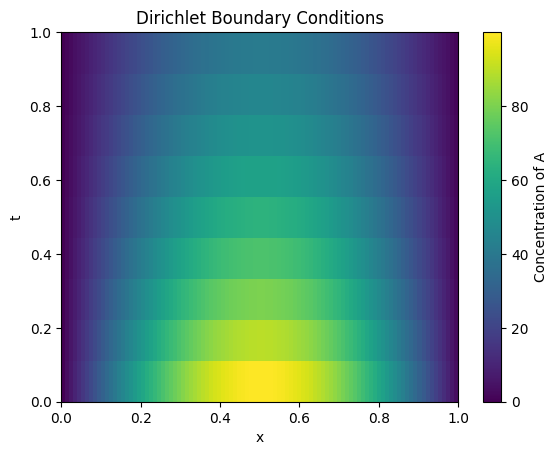

PyObject <matplotlib.text.Text object at 0x000000002DA01A20>

In [18]:
# Making heat map based off of calulated u
draw_heat_map(x, t, u)

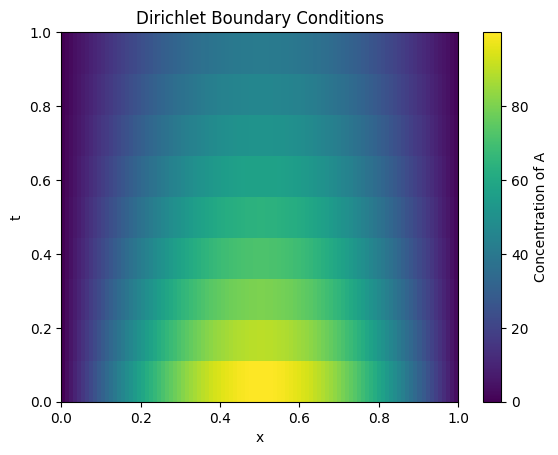

PyObject <matplotlib.text.Text object at 0x000000002DBF9588>

In [21]:
draw_heat_map(x, t, u_e)

In [22]:
u

100×10 Array{Float64,2}:
  0.0       0.0       0.0       0.0      …   0.0       0.0       0.0    
  3.17279   2.83951   2.54093   2.27373      1.45787   1.30456   1.16737
  6.34239   5.67615   5.07929   4.54517      2.91428   2.60781   2.33357
  9.5056    8.50708   7.61255   6.81203      4.36775   3.90844   3.49742
 12.6592   11.3294   10.1381    9.07204      5.81682   5.20512   4.65775
 15.8001   14.1404   12.6535   11.3229   …   7.26004   6.49657   5.81339
 18.9251   16.9371   15.1562   13.5624       8.69595   7.78147   6.96317
 22.0311   19.7168   17.6435   15.7882      10.1231    9.05854   8.10594
 25.1148   22.4766   20.1131   17.9981      11.5401   10.3265    9.24055
 28.1733   25.2138   22.5625   20.1899      12.9454   11.584    10.3659 
 31.2033   27.9256   24.9891   22.3614   …  14.3377   12.8299   11.4807 
 34.202    30.6092   27.3906   24.5103      15.7156   14.0629   12.584  
 37.1662   33.2621   29.7645   26.6346      17.0776   15.2817   13.6747 
  ⋮                       

In [23]:
u_e

100×10 Array{Float64,2}:
  0.0           0.0           0.0          …   0.0           0.0        
  3.17279       2.83943       2.54083          1.30451       1.16732    
  6.34239       5.676         5.07911          2.6077        2.33347    
  9.5056        8.50686       7.61227          3.90827       3.49727    
 12.6592       11.3291       10.1378           5.2049        4.65755    
 15.8001       14.14         12.6531       …   6.49629       5.81314    
 18.9251       16.9367       15.1556           7.78115       6.96287    
 22.0311       19.7163       17.6429           9.05816       8.1056     
 25.1148       22.476        20.1124          10.3261        9.24016    
 28.1733       25.2131       22.5617          11.5836       10.3654     
 31.2033       27.9248       24.9882       …  12.8294       11.4802     
 34.202        30.6084       27.3896          14.0623       12.5835     
 37.1662       33.2612       29.7634          15.2811       13.6741     
  ⋮                       

In [24]:
#Further shows the calculated u is correct
@assert(isapprox(u, u_e, rtol=.001), "Matrices are not equivalent.")